# Cooling Machine Optimization

by: Made PUTRA

`Prompt`: You are going to optimize the operation of a cooling machine. The engineering team tells you that it can be turned off when the external temperature is below 5 degrees but must be on otherwise. On top of this, the machine has to remain on for at least 2 hours when it is on, and off for at least 2 hours when it is off. The optimization step is one hour (i.e., every hour we have to send an on/off setpoint). Write a function that returns the setpoints that you would send to this cooling machine given the current status of the machine (is it on or off and for how long it has been this way), current external temperature and prediction of future external temperature and show how it works with an example. 

`Requirement`
- Machine turn-off ambient temperature set point: 5 deg. C.
- min. on/ff cycle:  2 hours
- optimization frequency: 1 hour
- command type: binary (on/off)

`input`: 
- external temperature
- machine feedback status (on/off)
- predicted of future external temperature

assumptions:
- the two hour time threshold is defined as transient period where the equipment has to remain doing of what it is currently doing, after reacing the two hour period, the equipment is defined as `steady_state`
- data logging frequency (assumed every 1 hour, or on every iteration)
- optimization program is expected to send the output right after it received data without waiting for the next iteration, given the steady state is reached.
- if steady state is not reached, the program will send the the previous command, thus holding the machine setpoint status

## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from IPython.display import clear_output
import math
import time
import traceback

## Generating Dummy Temperature Data with Predicted Future Temmperature

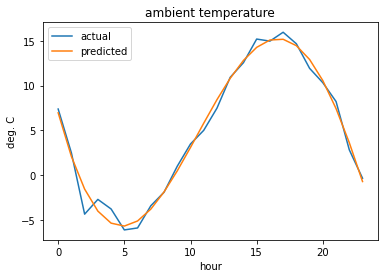

In [3]:
def generateTemps():
    """
    temperatures are generated using a noised sine wave for 24 hour period
    predicted temperature is predicted using a degree-5 polinomial equation based on the hour
    """
    mean_temp = 5
    st_dev = 1.5
    num_data = 24

    oa_t = np.random.normal(mean_temp,st_dev,num_data)
    daily_fluctuation = 10 * np.sin(np.arange(num_data) * (-2.25 *np.pi / num_data))
    oa_t += daily_fluctuation

    x = np.arange(len(oa_t))
    y = oa_t

    x= x[:,np.newaxis]
    y= y[:,np.newaxis]

    polynomial_features= PolynomialFeatures(degree=5)
    xp = polynomial_features.fit_transform(x)
    model = sm.OLS(y, xp).fit()
    oa_t_pred = model.predict(xp)

    return oa_t, oa_t_pred

oa_t, oa_t_pred = generateTemps()
plt.plot(oa_t, label="actual")
plt.plot(oa_t_pred, label="predicted")
plt.xlabel("hour")
plt.ylabel("deg. C")
plt.title("ambient temperature")
plt.legend()
plt.show()

# Optimization Program

Variables:
* `steady_state`: condition states the machine had passed the 2 hour minimum on/off.
* `on_count`: indicator of how many hours the equipment has been running condition.
* `off_count`: indicator of how many hours the quipment has been in idle condition.
* `time_th`: the minimum duration threshold for the euipment to reach steady state condition.
* `oa_t`: outside air temprature.
* `oa_t_pred`: predicted outside air temperature.
* `epoch`: number of iteration. 
* `curr_hour`: current hour.
* `future_hour`: 1 hour ahead of the current hour.
* `machine_cmd`: machine running status setpoint, `0` indicating the equipment is idle, while `1` is indicating the equipment is running.
* `machine_status`: machine running status history.

Information about the script:
- the script will run in loop every seconds and will generate the graph and append the values according to how long the script had been running.


curr_hour: 7
curr_temp: -3.271854859305229
future_temp: -0.9700854244698056

on_count: 0
off_count: 7
steady_state: True

sending machine status: 0


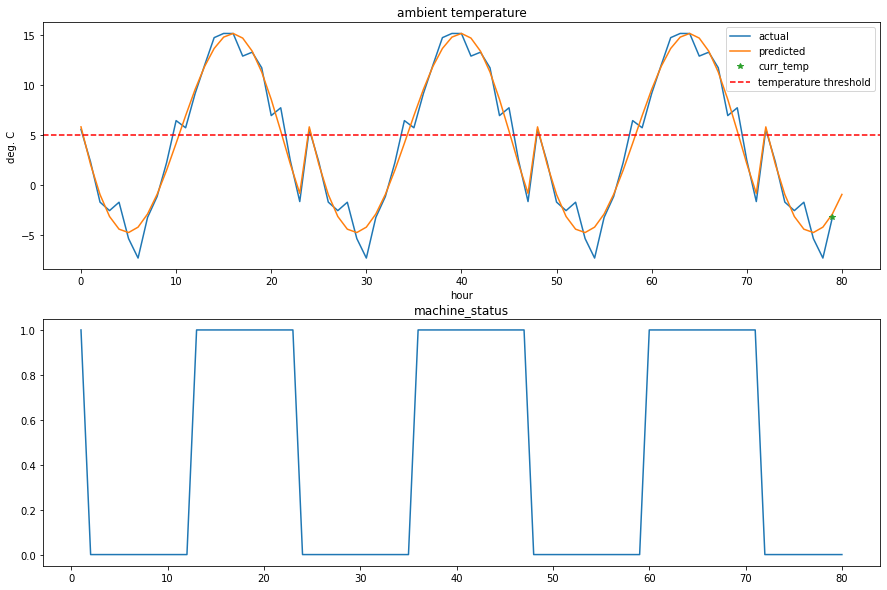

epoch: 80


In [12]:
# initiating optimization variables
steady_state = False
on_count = 0
off_count = 0
timer_th = 2 #hours
curr_hour = 24
        
epoch = 0
machine_status = []

generated_temps = generateTemps()

while True:
    clear_output(wait=True)  # Clear the previous output
    future_hour = curr_hour + 1

    # extending the dummy data for the next days iteration
    if epoch > 23:
        oa_t = np.concatenate([generated_temps[0]]*((math.floor((epoch)/24)+1)))
        oa_t_pred = np.concatenate([generated_temps[1]]*((math.floor((epoch)/24)+1)))
    else:
        pass

    if curr_hour > 23:
        curr_hour = curr_hour%24
    
    if future_hour > 23:
        future_hour = future_hour%24

    curr_temp = oa_t[curr_hour]
    future_temp = oa_t_pred[future_hour] 

    try:
        # counting the running/idle status
            # the on_count is reset when the off_count value is >= 0, and vice versa
        if curr_temp < 5:
            off_count += 1
            on_count = 0 
        elif curr_temp >= 5:
            on_count += 1
            off_count = 0
        else:
            print("invalid temperature input")
            break
        
        # determining the steady_state from the on/off_count
        if off_count >= timer_th or on_count >= timer_th:
            steady_state = True
        else:
            steady_state = False

        if steady_state == True:
            if curr_temp < 5:
                machine_cmd = 0
            else:
                machine_cmd = 1
        else:
            if len(machine_status) < 2:
                machine_cmd = None #initialization value is set to None
            elif len(machine_status) == 2: # command will be send after two after initialization
                if curr_temp < 5:
                    machine_cmd = 0
                else:
                    machine_cmd = 1 
            else: 
                machine_cmd = machine_status[-1]

        machine_status.append(machine_cmd)

        # displaying the input and output parameters
        print("")
        print("curr_hour: " + str(curr_hour))
        print("curr_temp: " + str(curr_temp))
        print("future_temp: " + str(future_temp))
        print("")
        print("on_count: " + str(on_count))
        print("off_count: " + str(off_count))
        print("steady_state: " + str(steady_state))
        print("")
        print("sending machine status: " + str(machine_cmd)) # on the actual practice, this will be the value through to the equipment  communication protocol

        # plotting the result
        plt.figure(figsize=(15,10))
        plt.subplot2grid((2,1),(0,0))
        plt.plot(oa_t[:epoch+1], label="actual")
        plt.plot(oa_t_pred[:epoch+2], label="predicted")
        plt.plot(epoch,oa_t[epoch],"*",label="curr_temp") 
        plt.axhline(y=5,linestyle='dashed',color="r",label='temperature threshold')
        plt.xlabel("hour")
        plt.ylabel("deg. C")
        plt.title("ambient temperature")
        plt.legend()
        plt.subplot2grid((2,1),(1,0))
        plt.plot(machine_status)
        plt.title("machine_status")
        plt.show()

        if machine_cmd != None:
            epoch += 1
            curr_hour += 1
        print("epoch: " + str(epoch))
        time.sleep(1) #hour, one second is used for demonstration purposes
    except :
        traceback.print_exc()
        time.sleep(0)